In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
df = pd.read_csv('orders.csv')
df

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376
...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368
5005,169320,2017-07-23,Second,LH-16900,171.430
5006,169488,2017-09-07,First,AA-10375,56.860
5007,169502,2017-08-28,Standard,MG-17650,113.410


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           5009 non-null   int64  
 1   order_date   5009 non-null   object 
 2   ship_mode    5009 non-null   object 
 3   customer_id  5009 non-null   object 
 4   sales        5009 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 195.8+ KB


In [4]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df

In [5]:
def draw_retantion_diagram(data, width=25, height=20, title=''):
    """
    Сalculates client retention and draws a diagram
    """
    cohorts_group = data.groupby(['cohort', 'order_date']).agg({'customer_id': pd.Series.nunique})
    cohorts_group.rename(columns={'customer_id': 'TotalUsers',
                            'order_date': 'TotalOrders'}, inplace=True)
    cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
    cohorts_group.reset_index(inplace=True)
    cohorts_group.set_index(['cohort', 'CohortPeriod'], inplace=True) 
    cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
    user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
    sns.set(style='white')
    plt.figure(figsize=(width, height))
    plt.title(f'Cohorts: User Retention {title}', fontsize=16)
    sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');
    return user_retention.T

### Годовой retention

Для начала посмострим как ведет себя **retention** за год, чтобы понять общую картину.

In [6]:
df['order_date'] = pd.to_datetime(df['order_date'], infer_datetime_format=True)
df['order_date'] = df['order_date'].dt.strftime('%Y') 
df

,id,order_date,ship_mode,customer_id,sales
0,100006,2014,Standard,DK-13375,377.970
1,100090,2014,Standard,EB-13705,699.192
2,100293,2014,Standard,NF-18475,91.056
3,100328,2014,Standard,JC-15340,3.928
4,100363,2014,Standard,JM-15655,21.376
...,...,...,...,...,...
5004,168802,2017,Standard,JO-15145,18.368
5005,169320,2017,Second,LH-16900,171.430
5006,169488,2017,First,AA-10375,56.860
5007,169502,2017,Standard,MG-17650,113.410


In [7]:
cohorts = df.groupby('customer_id', as_index=False)['order_date'].min()
cohorts.rename(columns = {'order_date': 'cohort'}, inplace=True)
cohorts

,customer_id,cohort
0,AA-10315,2014
1,AA-10375,2014
2,AA-10480,2014
3,AA-10645,2014
4,AB-10015,2014
...,...,...
788,XP-21865,2014
789,YC-21895,2014
790,YS-21880,2015
791,ZC-21910,2014


In [8]:
df_merged = pd.merge(df, cohorts, how='left', on='customer_id')
df_merged

,id,order_date,ship_mode,customer_id,sales,cohort
0,100006,2014,Standard,DK-13375,377.970,2014
1,100090,2014,Standard,EB-13705,699.192,2014
2,100293,2014,Standard,NF-18475,91.056,2014
3,100328,2014,Standard,JC-15340,3.928,2014
4,100363,2014,Standard,JM-15655,21.376,2014
...,...,...,...,...,...,...
5004,168802,2017,Standard,JO-15145,18.368,2014
5005,169320,2017,Second,LH-16900,171.430,2014
5006,169488,2017,First,AA-10375,56.860,2014
5007,169502,2017,Standard,MG-17650,113.410,2014


CohortPeriod,0,1,2,3
cohort,,,,
2014,1.0,0.734454,0.815126,0.868908
2015,1.0,0.750000,0.882353,NaN
2016,1.0,0.882353,NaN,NaN
2017,1.0,NaN,NaN,NaN


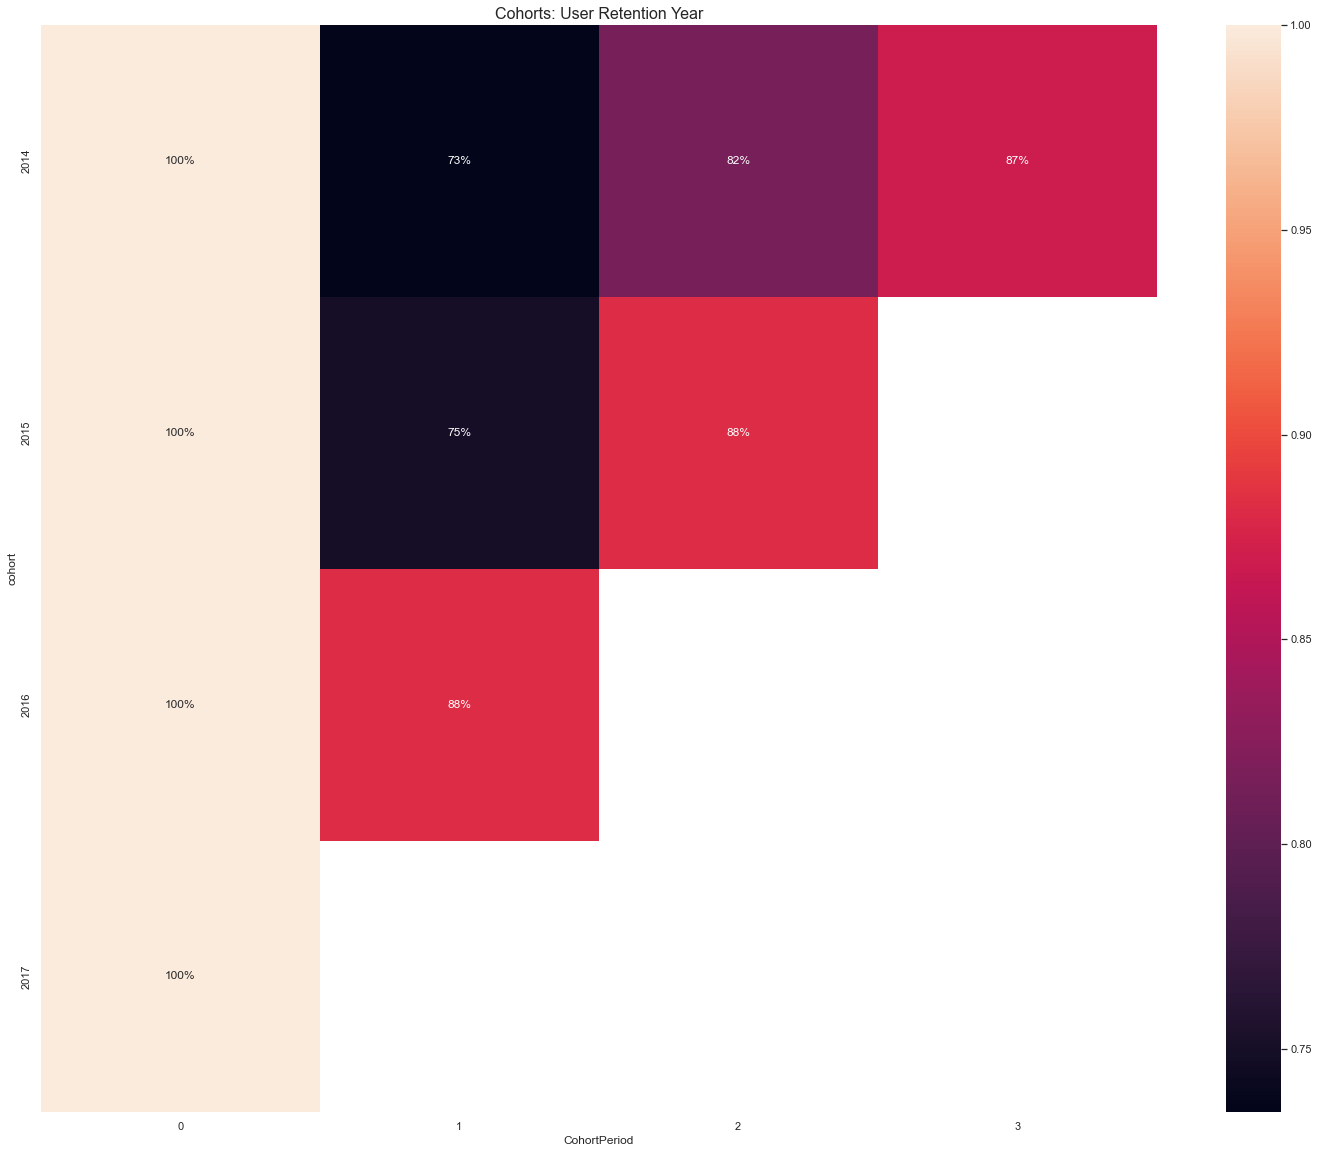

In [9]:
draw_retantion_diagram(df_merged, title='Year')

Видим, что, несмотря на возможные проблемы с доставкой товаров, годовой retention даже возрос (для пользователей, совершивших первую покупку в 2014 году - на 5%, а в 2015 - на 13%). Это говорит о том, что за 2017 год были привлечены давние клиенты, которые ушли от нас ранее. Но все-таки 1 год - это слишком большое временное окно для интернет-магазина (хотелось бы, чтобы покупатели приходили чаще, чем раз в год). 

Взглянем теперь на месячную динамику:

### Retention по месяцам

In [10]:
df = pd.read_csv('orders.csv')

In [11]:
df['order_date'] = pd.to_datetime(df['order_date'],infer_datetime_format=True)
df['order_date'] = df['order_date'].dt.strftime('%Y-%m') 
df

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09,Standard,DK-13375,377.970
1,100090,2014-07,Standard,EB-13705,699.192
2,100293,2014-03,Standard,NF-18475,91.056
3,100328,2014-01,Standard,JC-15340,3.928
4,100363,2014-04,Standard,JM-15655,21.376
...,...,...,...,...,...
5004,168802,2017-11,Standard,JO-15145,18.368
5005,169320,2017-07,Second,LH-16900,171.430
5006,169488,2017-09,First,AA-10375,56.860
5007,169502,2017-08,Standard,MG-17650,113.410


In [12]:
cohorts = df.groupby('customer_id', as_index=False)['order_date'].min()
cohorts.rename(columns = {'order_date': 'cohort'}, inplace=True)
cohorts

,customer_id,cohort
0,AA-10315,2014-03
1,AA-10375,2014-04
2,AA-10480,2014-05
3,AA-10645,2014-06
4,AB-10015,2014-02
...,...,...
788,XP-21865,2014-01
789,YC-21895,2014-11
790,YS-21880,2015-01
791,ZC-21910,2014-10


In [13]:
df_merged = pd.merge(df, cohorts, how='left', on='customer_id')
df_merged

,id,order_date,ship_mode,customer_id,sales,cohort
0,100006,2014-09,Standard,DK-13375,377.970,2014-09
1,100090,2014-07,Standard,EB-13705,699.192,2014-07
2,100293,2014-03,Standard,NF-18475,91.056,2014-03
3,100328,2014-01,Standard,JC-15340,3.928,2014-01
4,100363,2014-04,Standard,JM-15655,21.376,2014-04
...,...,...,...,...,...,...
5004,168802,2017-11,Standard,JO-15145,18.368,2014-01
5005,169320,2017-07,Second,LH-16900,171.430,2014-08
5006,169488,2017-09,First,AA-10375,56.860,2014-04
5007,169502,2017-08,Standard,MG-17650,113.410,2014-08


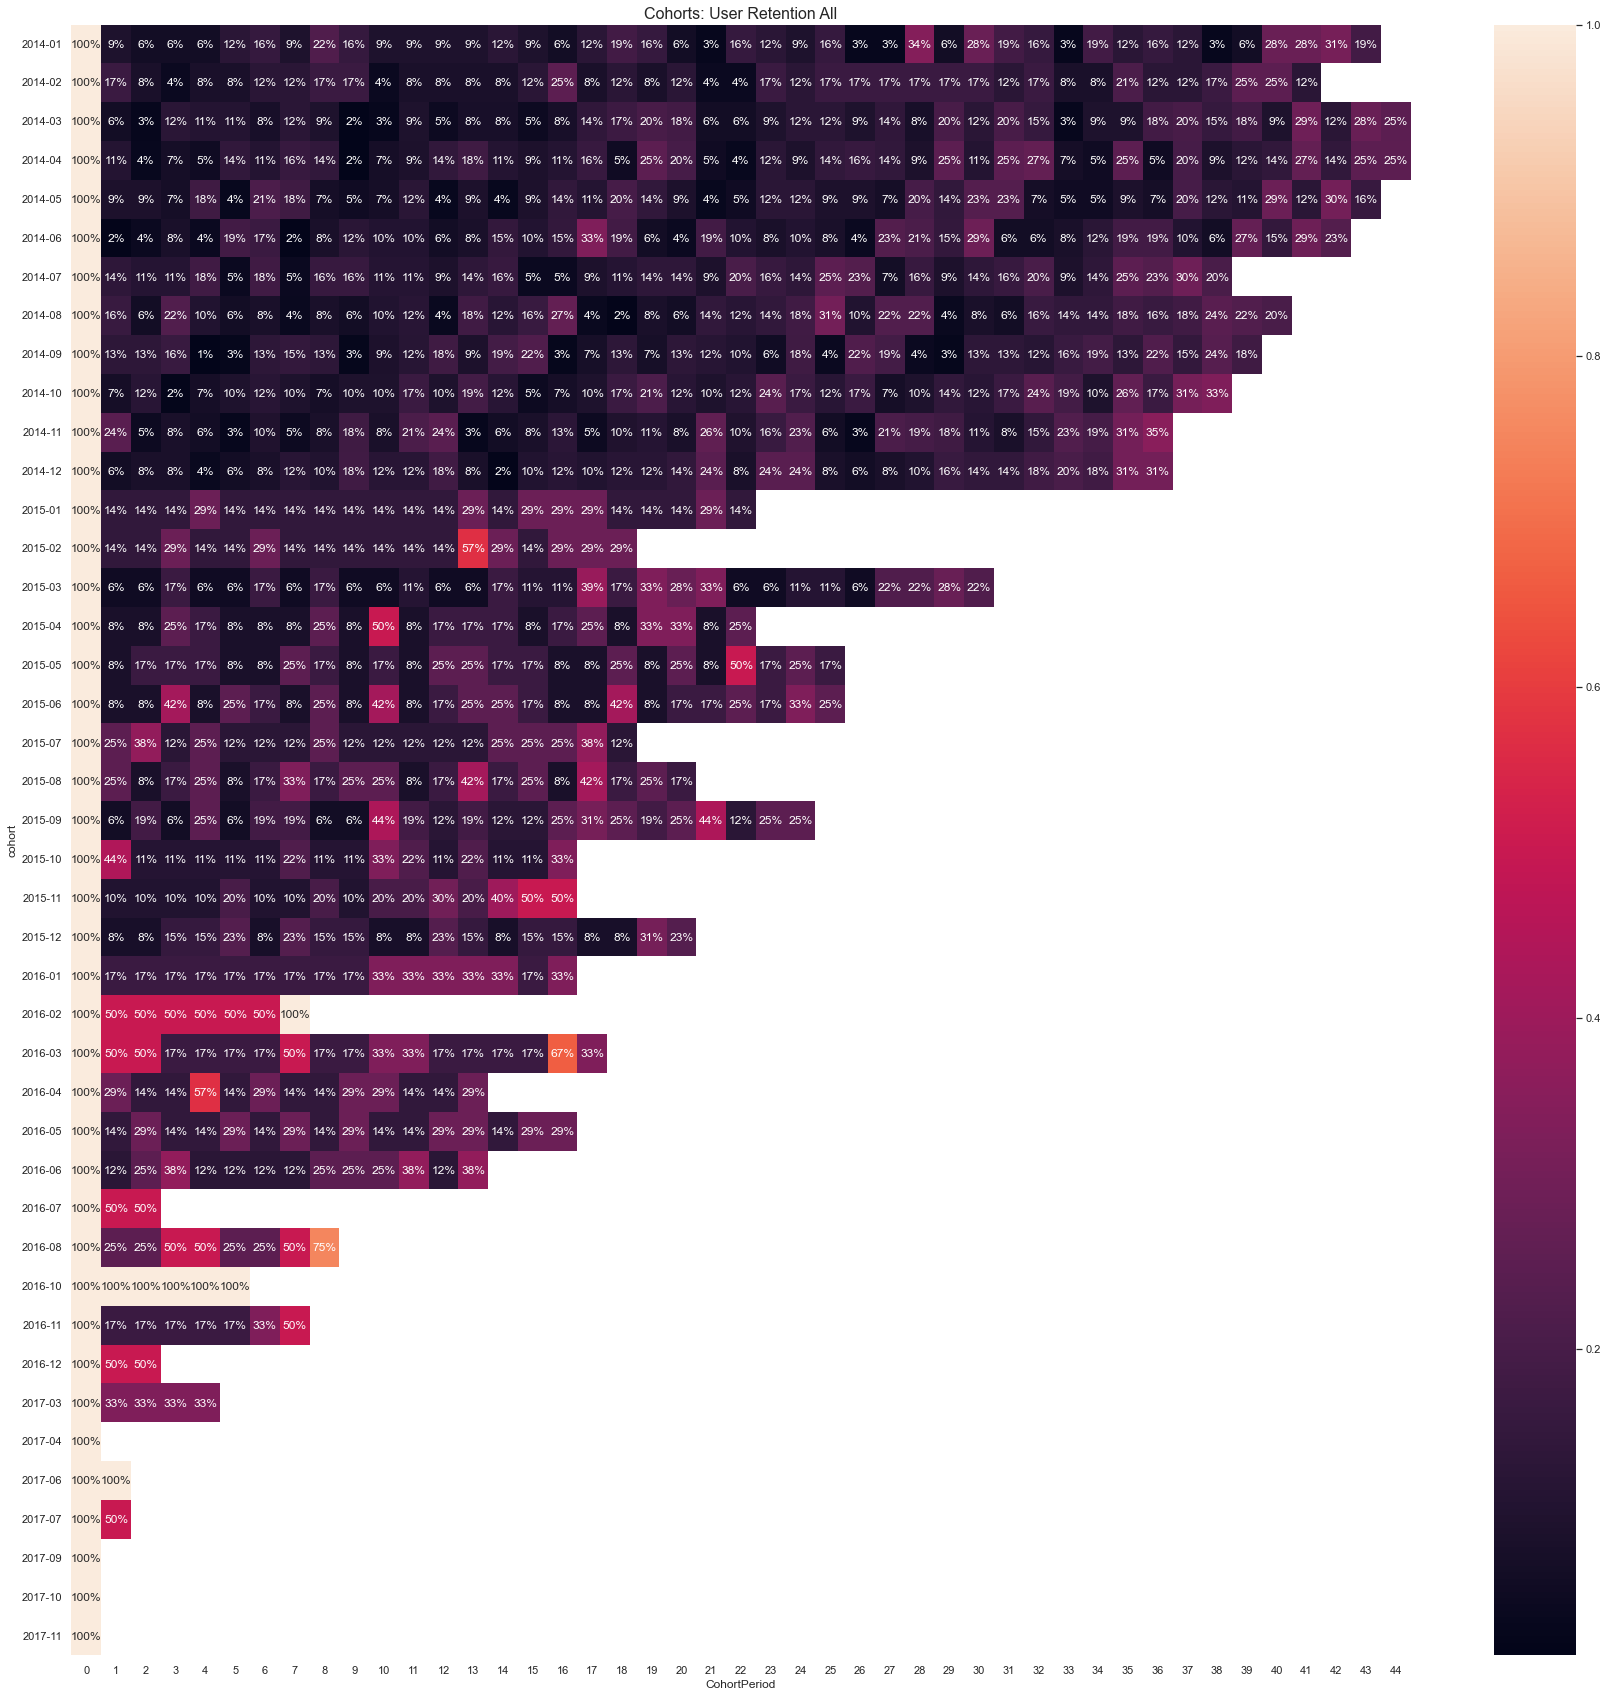

In [14]:
draw_retantion_diagram(df_merged, width=30, height=30, title='All');

Рассмотрим более подробно ситуацию для пользователей, пришедших непосредственно в 2016 и 2017 годах:

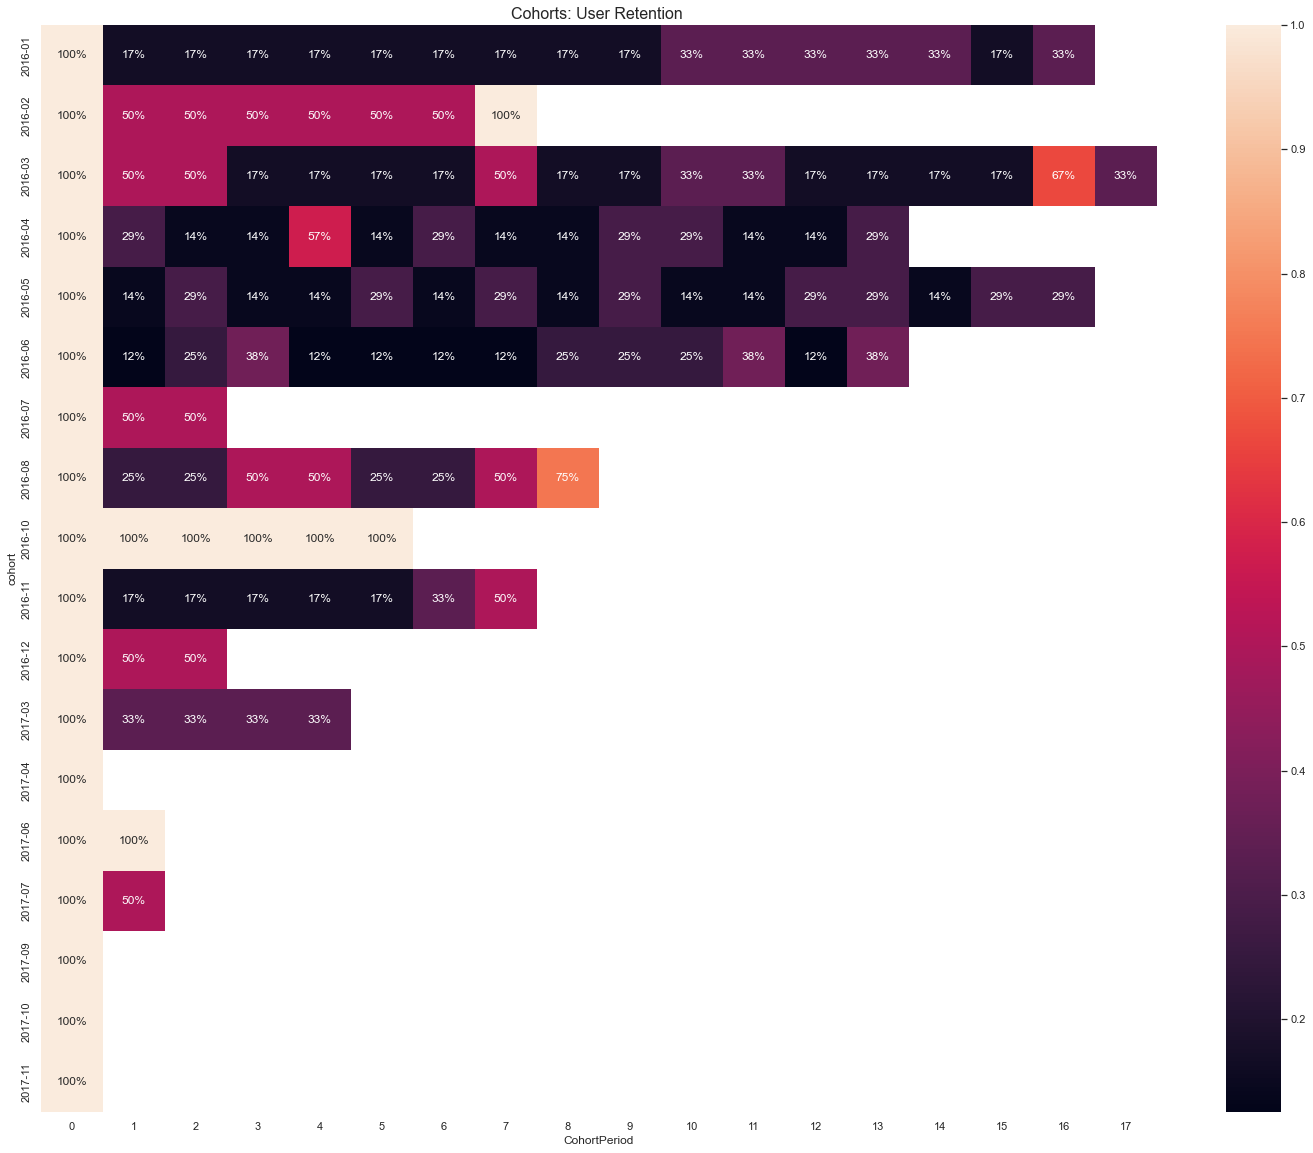

In [15]:
df_merged_cut = df_merged[df_merged['cohort'].str.contains('2017|2016')]
draw_retantion_diagram(df_merged_cut);

Проблемы:
-  не смогли привлечь новых пользователей в сентябре 2016 (2016-09), а также зимой 2017 (2017-01, 2017-02) - это надо учитывать при анализе диаграммы;
- с 2017 года имеются очевидные проблемы с возвращаемостью в первый месяц после покупок (2017-04, 2017-09, 2017-10, 2017-11 пользователи ушли и больше не вернулись). Весьма вероятно, что это влияние проблем с доставкой (клиент совершил покупку впервые, сразу же получил негативный опыт и решил больше не пользоваться данным магазином). В 2016 же году таких ситуаций не наблюдалось. 

Однако, скорее это связано с тем, что в исследуемых когортах мало пользователей.


### Количество новых клиентов

Посмотрим как хорошо магазин привлекает новых клиентов:

In [16]:
clients = []
years = []
for i in range(4):
    current_year = 2014+i
    years.append(str(current_year))
    clients.append(len(df_merged[df_merged['cohort'].str.contains(f'{current_year}')])) 
clients
years

['2014', '2015', '2016', '2017']

Text(0, 0.5, 'Число клиентов')

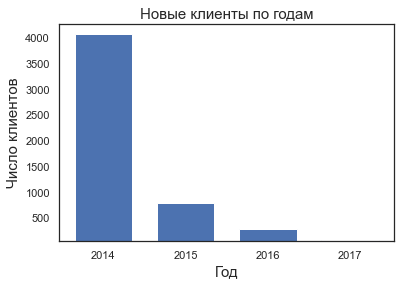

In [17]:
plt.bar(years, clients, width=0.7, bottom=50)
plt.title('Новые клиенты по годам', fontsize=15)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Число клиентов', fontsize=15)

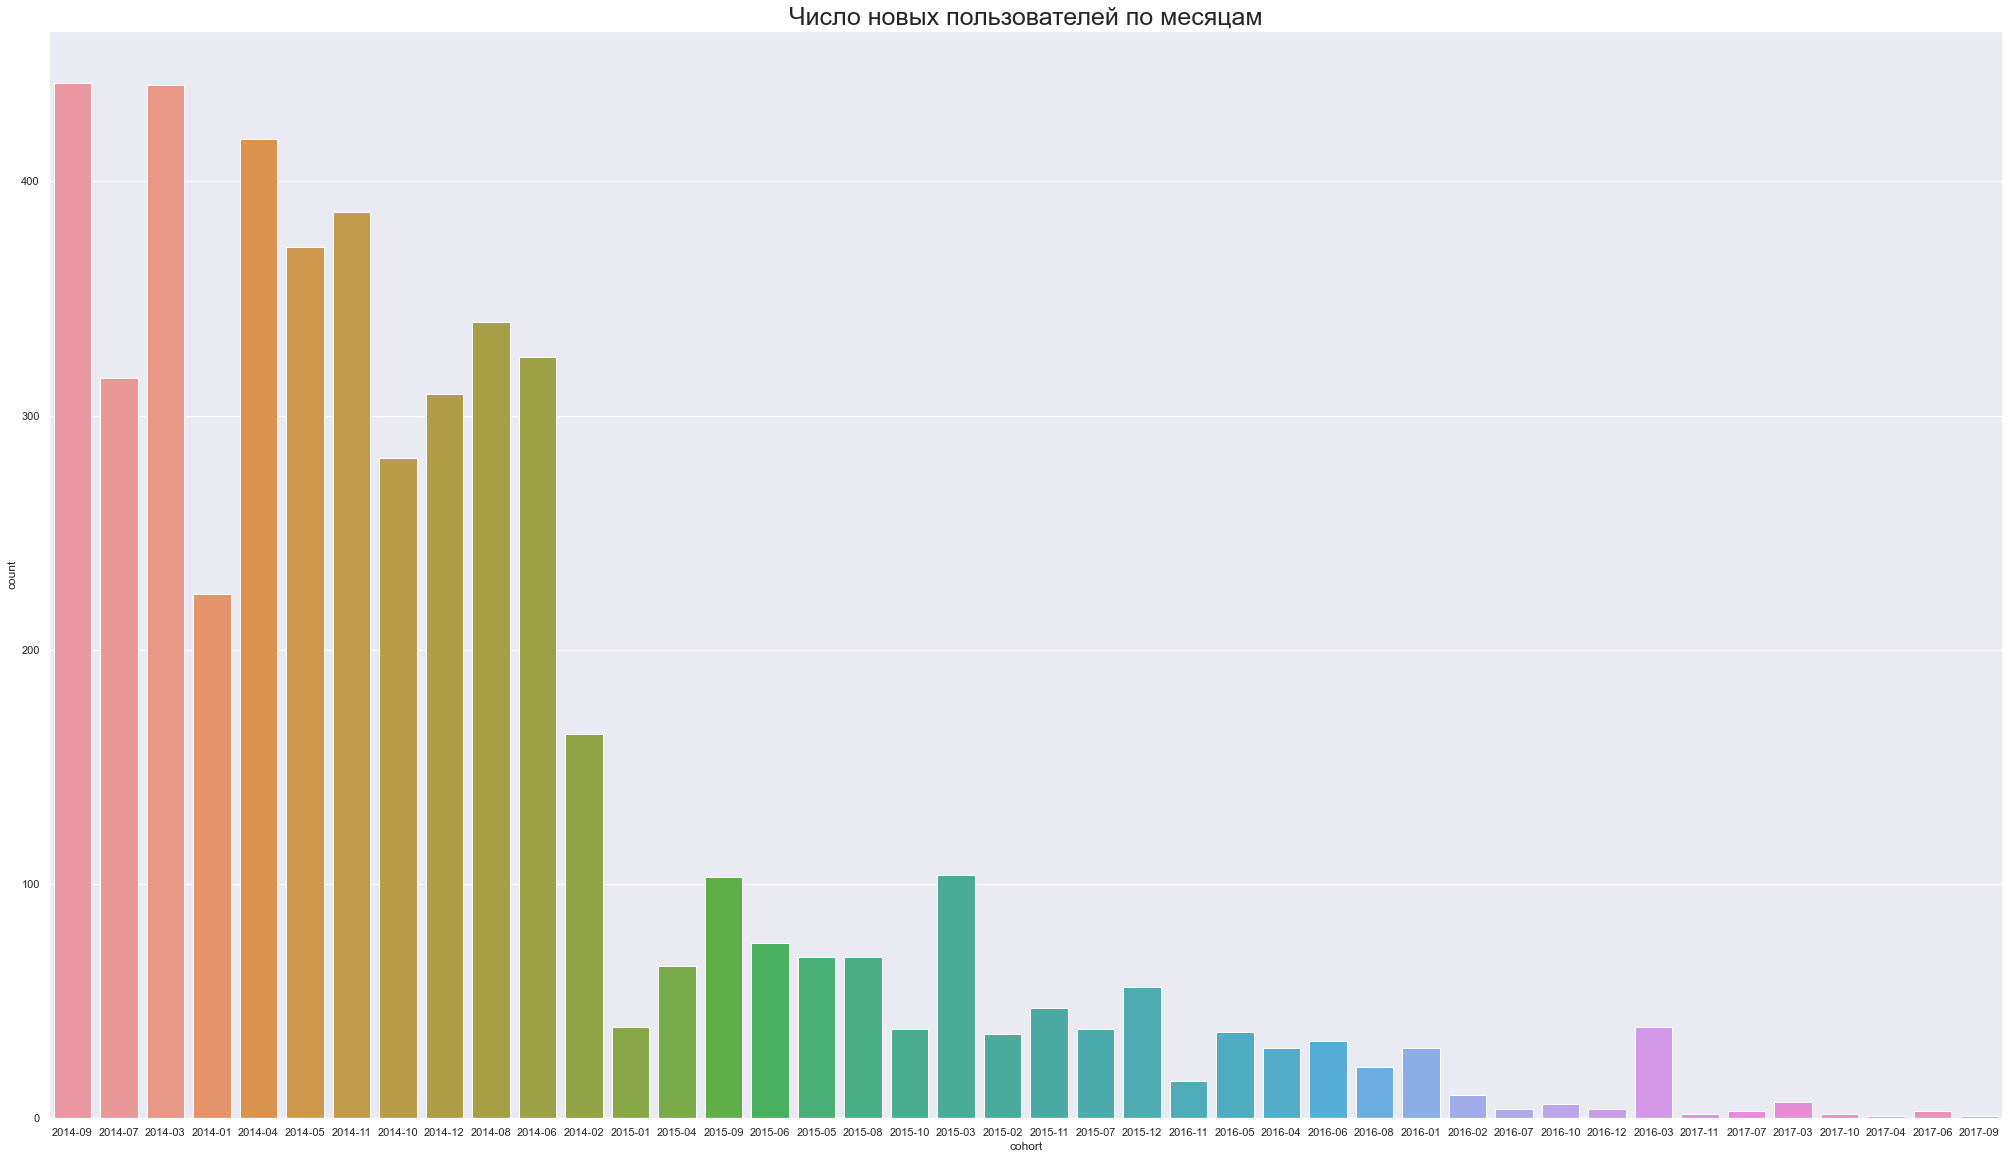

In [18]:
sns.set(rc={'figure.figsize':(35, 20)})
ax = sns.countplot(x="cohort", data=df_merged).set_title('Число новых пользователей по месяцам', fontsize=25);

Таким образом, видим, что магазин **почти не привлекает новых клиентов**. Основная масса была привлечена в 2014 и 2015 годах, поэтому нужно сосредоточиться именно на этих людях.

### Среднемесячный retention для клиентов 2014 и 2015 годов

Рассмотрим когорты за 2014 и 2015 годы:

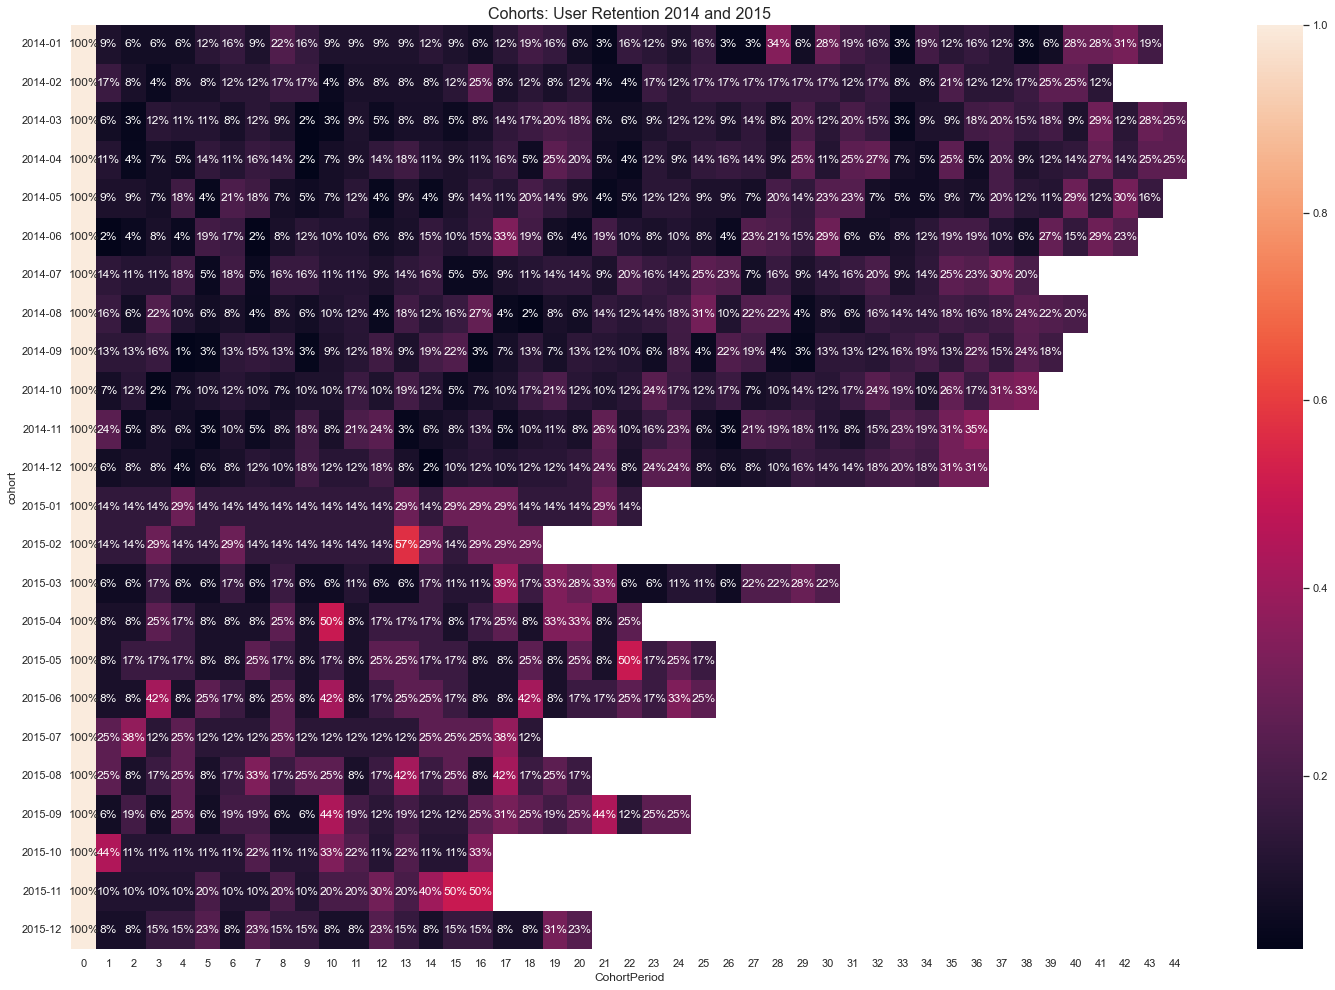

In [19]:
df_merged_cut = df_merged[df_merged['cohort'].str.contains('2014|2015')]
ur = draw_retantion_diagram(df_merged_cut.fillna(0), width=25, height=17, title='2014 and 2015');

Рассчитаем средний показатель retention по каждому месяцу для клиентов 2014 и 2015 года.  
Для этого просуммируем соответсвующие побочные диагонали матрицы и поделим на общее количество элементов в них. Учтем при этом, что в январе и феврале 2017 года (24 и 25 период) новых клиентов не было, поэтому исключим их рассмотрения.  
Так, для того чтобы рассчитать средний показатель retention в марте, необходимо начать с 26 периода матрицы (т.е. просуммировать 16% + 12% + 9% + 4% + ... + 19% + 11% + 9% + 15% и поделить на общее число элементов данной диагонали).  
Проведем такой расчет для каждого из 9 месяцев (январь, февраль и сентябрь исключаем так как в эти месяцы не были привлечены новые клиенты, поэтому информация об этих месяцах в матрице пропущена).

In [20]:
# исключаем неудобные индексы
ur_reset = ur.reset_index(drop=True)

In [21]:
n_empty = 3 # количество месяцев, в которых не было новых клиентов
months = 12 - n_empty  
s_2016 = 0 # сумма значений retention по каждому месяцу в 2016 году 
s_2017 = 0 # сумма значений retention по каждому месяцу в 2017 году
n = 0
month_retention_2016 = np.array([]) # массив, содержащий средний retention по каждому месяцу в 2016 году
month_retention_2017 = np.array([]) # массив, содержащий средний retention по каждому месяцу в 2017 году
for month in range(months):
    l_2016 = 26 + month # (26 - номер когорты, соответствующий 2016-03)
    l_2017 = 35 + month # (25 - номер когорты, соответствующий 2017-03)
    for i in range(24):
        if not math.isnan(ur_reset[l_2016-i][i]):
            s_2016 += ur_reset[l_2016-i][i]
        if not math.isnan(ur_reset[l_2017-i][i]):
            s_2017 += ur_reset[l_2017-i][i]
        n += 1
    month_retention_2016 = np.append(month_retention_2016, s_2016/n)
    month_retention_2017 = np.append(month_retention_2017, s_2017/n)
    s_2016 = 0
    s_2017 = 0
    n = 0

In [22]:
# средний retention по каждому месяцу в 2016 году
month_retention_2016

array([0.15011211, 0.14334943, 0.16385419, 0.14444954, 0.15617526,
       0.1765064 , 0.18945059, 0.13922618, 0.18991765])

In [23]:
# средний retention по каждому месяцу в 2017 году
month_retention_2017

array([0.17938774, 0.12490463, 0.12888352, 0.1448148 , 0.1049104 ,
       0.11580423, 0.14341435, 0.11956276, 0.1102769 ])

In [24]:
# рассчитаем разницу между показателями 2016 и 2017 года
month_retention_2016 - month_retention_2017

array([-0.02927563,  0.0184448 ,  0.03497067, -0.00036526,  0.05126487,
        0.06070217,  0.04603624,  0.01966343,  0.07964075])

Видим, что retention в 2017 году лишь в 2 из 9 случаев превосходил показатели 2016 года.

Рассчитаем среднее значение разницы между 2016 и 2017 годом:

In [25]:
(month_retention_2016 - month_retention_2017).mean()

0.03123133751046878

### Вывод

Итак, в 2017 году retention упал в среднем на 3.1% по сравнению с 2016 годом. Это значит, что магазин теряет в среднем следующее количество клиентов:

In [26]:
int(df_merged_cut.groupby('cohort').count().mean()[0] * (month_retention_2016 - month_retention_2017).mean())

6

Таким образом, гипотеза руководителя оказалась верной - проблемы с доставкой, действительно, приводят с заметному ухудшению удержания клиентов (если, конечно, это не обусловлено другими факторами, которые мы не рассматривали).

### Retention в зависимости от типа доставки

In [27]:
df_merged['ship_mode'].unique()

array(['Standard', 'Second', 'First', 'Same Day'], dtype=object)

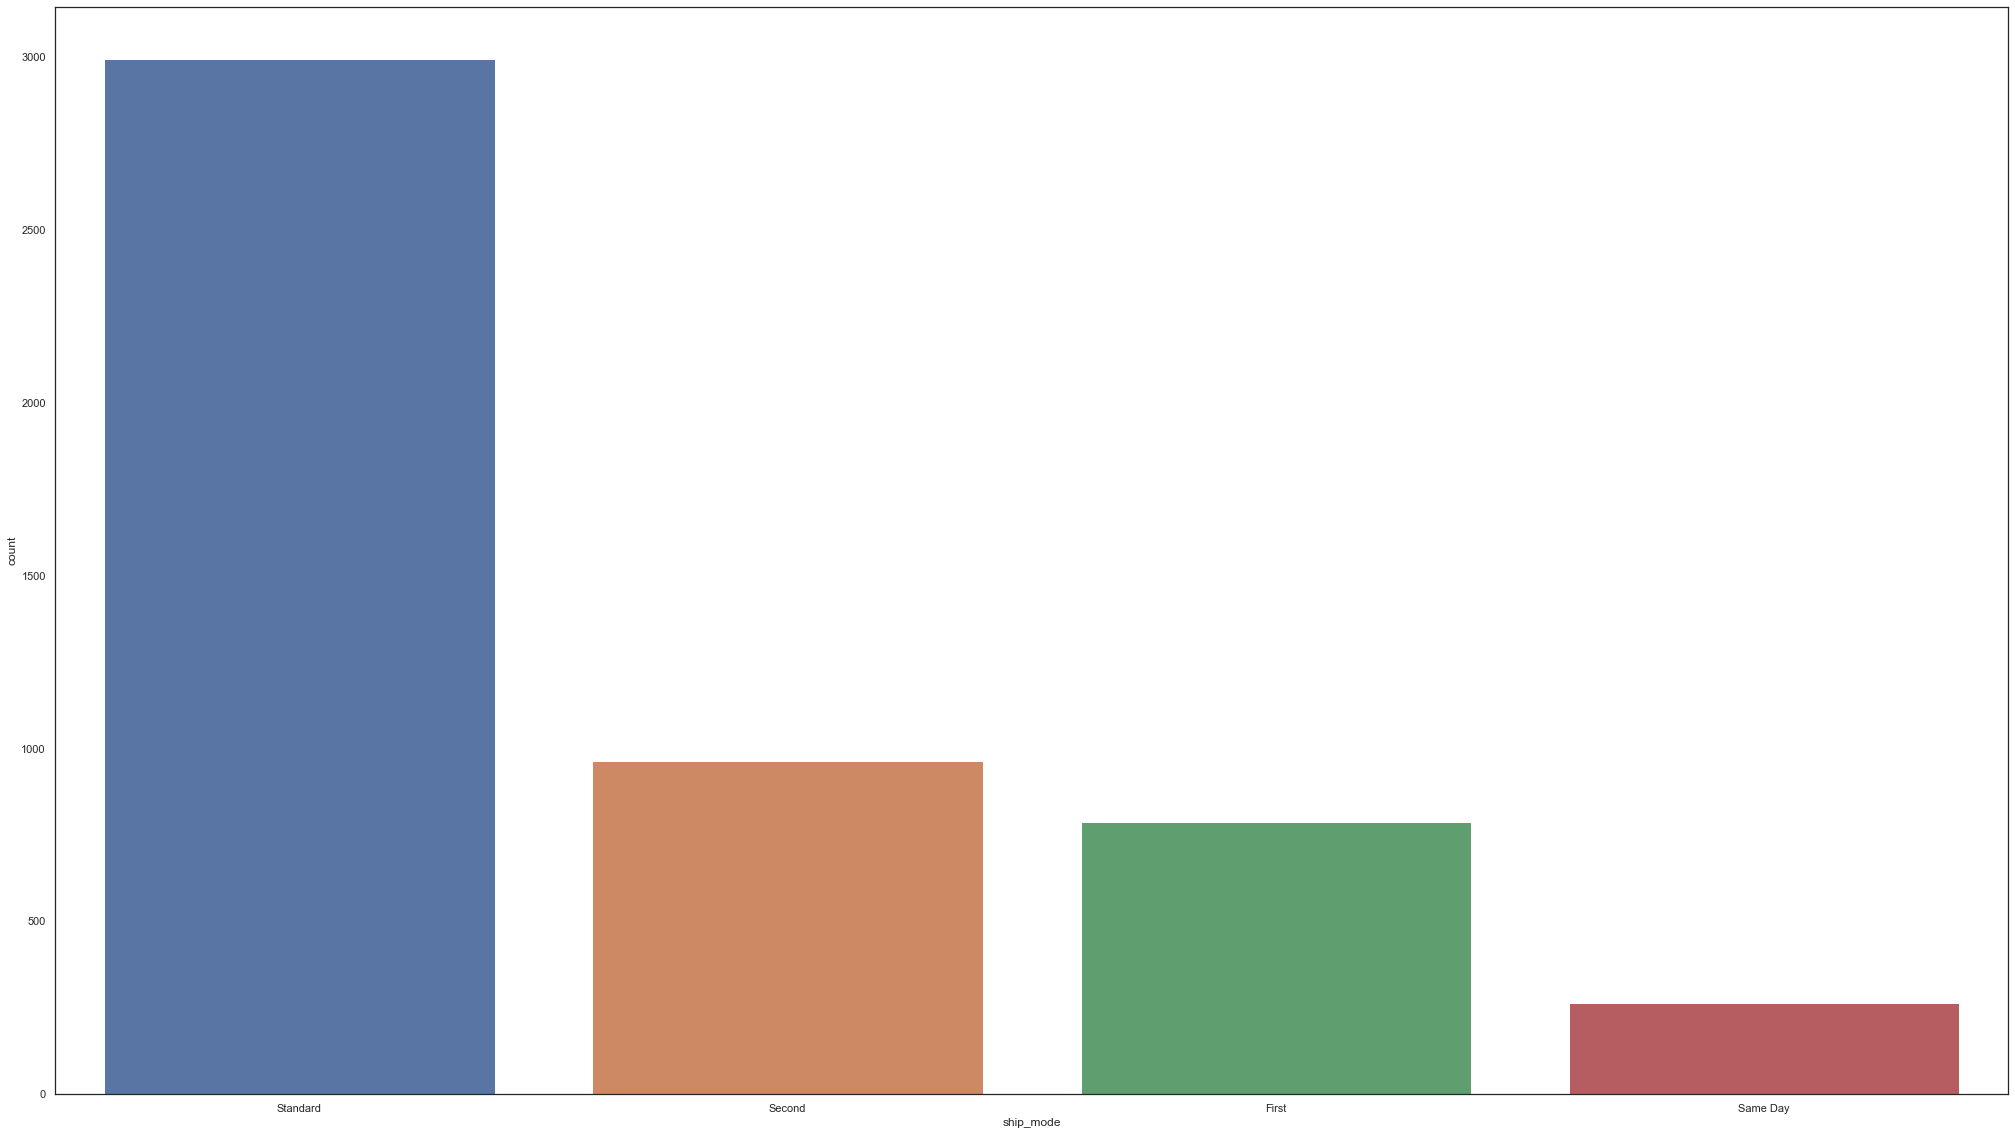

In [28]:
sns.countplot(x="ship_mode", data=df_merged);

#### Стандартная доставка

Видим, что имеется 4 вида доставки, преобладающей из которых явялется стандратная.   
Начнем с нее - проведем аналогичное исследование среднемесячного показателя удержания:

In [29]:
df_standard_ship = df_merged[df_merged['ship_mode'] == 'Standard']

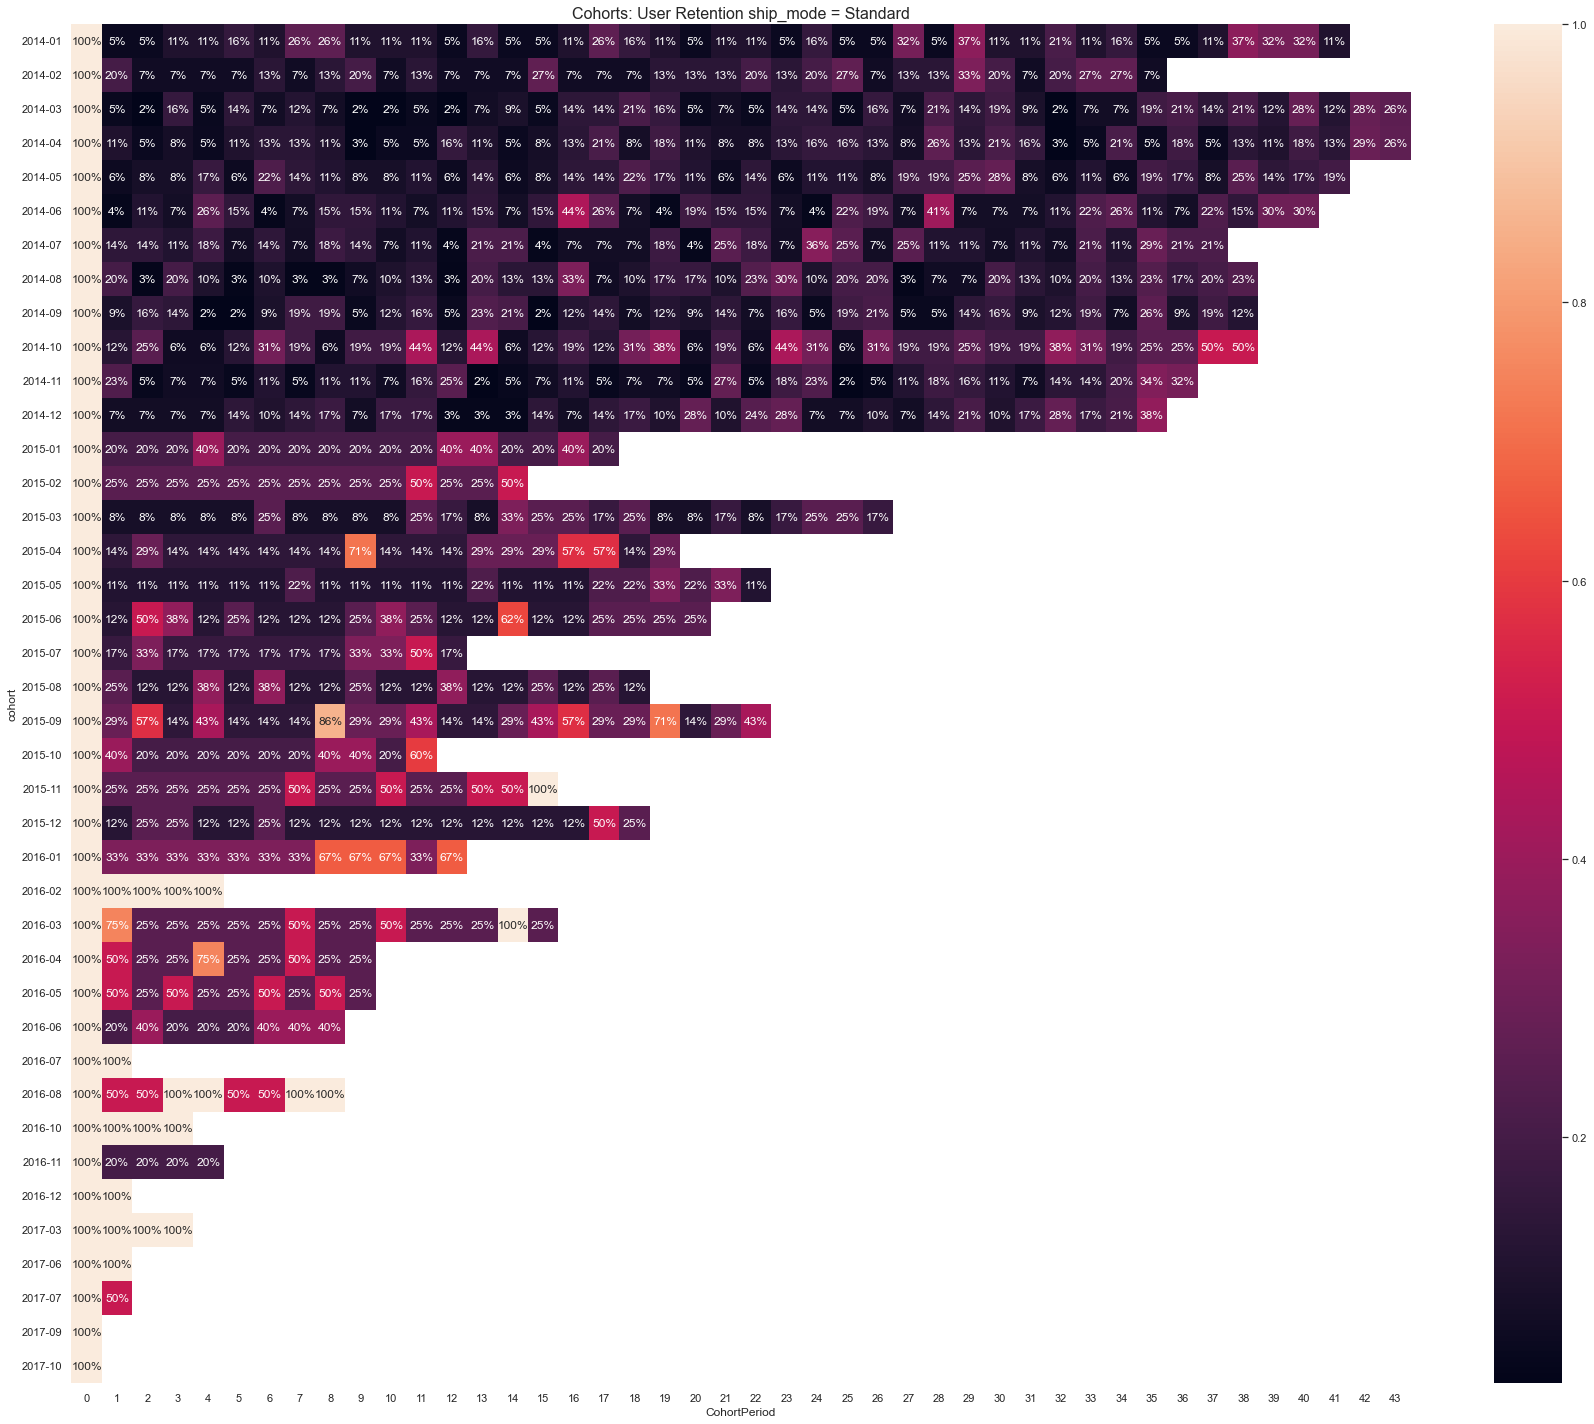

In [30]:
ur_standard_ship = draw_retantion_diagram(df_standard_ship, width=30, height=25, title='ship_mode = Standard');

In [31]:
# исключаем неудобные индексы
ur_reset = ur_standard_ship.reset_index(drop=True)

In [32]:
n_empty = 3 # количество месяцев, в которых не было новых клиентов
months = 12 - n_empty  
s_2016 = 0 # сумма значений retention по каждому месяцу в 2016 году 
s_2017 = 0 # сумма значений retention по каждому месяцу в 2017 году
n = 0
month_retention_2016 = np.array([]) # массив, содержащий средний retention по каждому месяцу в 2016 году
month_retention_2017 = np.array([]) # массив, содержащий средний retention по каждому месяцу в 2017 году
for month in range(months):
    l_2016 = 26 + month # (26 - номер когорты, соответствующий 2016-03)
    l_2017 = 35 + month # (25 - номер когорты, соответствующий 2017-03)
    for i in range(24):
        if not math.isnan(ur_reset[l_2016-i][i]):
            s_2016 += ur_reset[l_2016-i][i]
        if not math.isnan(ur_reset[l_2017-i][i]):
            s_2017 += ur_reset[l_2017-i][i]
        n += 1
    month_retention_2016 = np.append(month_retention_2016, s_2016/n)
    month_retention_2017 = np.append(month_retention_2017, s_2017/n)
    s_2016 = 0
    s_2017 = 0
    n = 0

In [33]:
# средний retention по каждому месяцу в 2016 году
month_retention_2016

array([0.15755515, 0.1807885 , 0.21000742, 0.1975955 , 0.17583005,
       0.21101014, 0.17991987, 0.16059308, 0.15104005])

In [34]:
# средний retention по каждому месяцу в 2017 году
month_retention_2017

array([0.13024476, 0.11915991, 0.16087645, 0.10617893, 0.12809813,
       0.10818666, 0.09158196, 0.10099127, 0.07600078])

In [35]:
# рассчитаем разницу между показателями 2016 и 2017 года
month_retention_2016 - month_retention_2017

array([0.02731039, 0.06162859, 0.04913096, 0.09141657, 0.04773192,
       0.10282348, 0.0883379 , 0.05960181, 0.07503927])

Видим, что retention в 2017 году для стандратной доставки всегда хуже, чем в 2016.

Рассчитаем среднее значение разницы между 2016 и 2017 годом:

In [36]:
(month_retention_2016 - month_retention_2017).mean()

0.06700232242477588

Таким образом, retention для стандратной доставки в 2017 году снизился еще больше (примерно на 6,7%).

#### Другие виды доставки

Посмотрим на другие виды доставки:

In [37]:
df_standard_ship = df_merged[df_merged['ship_mode'] == 'Second']

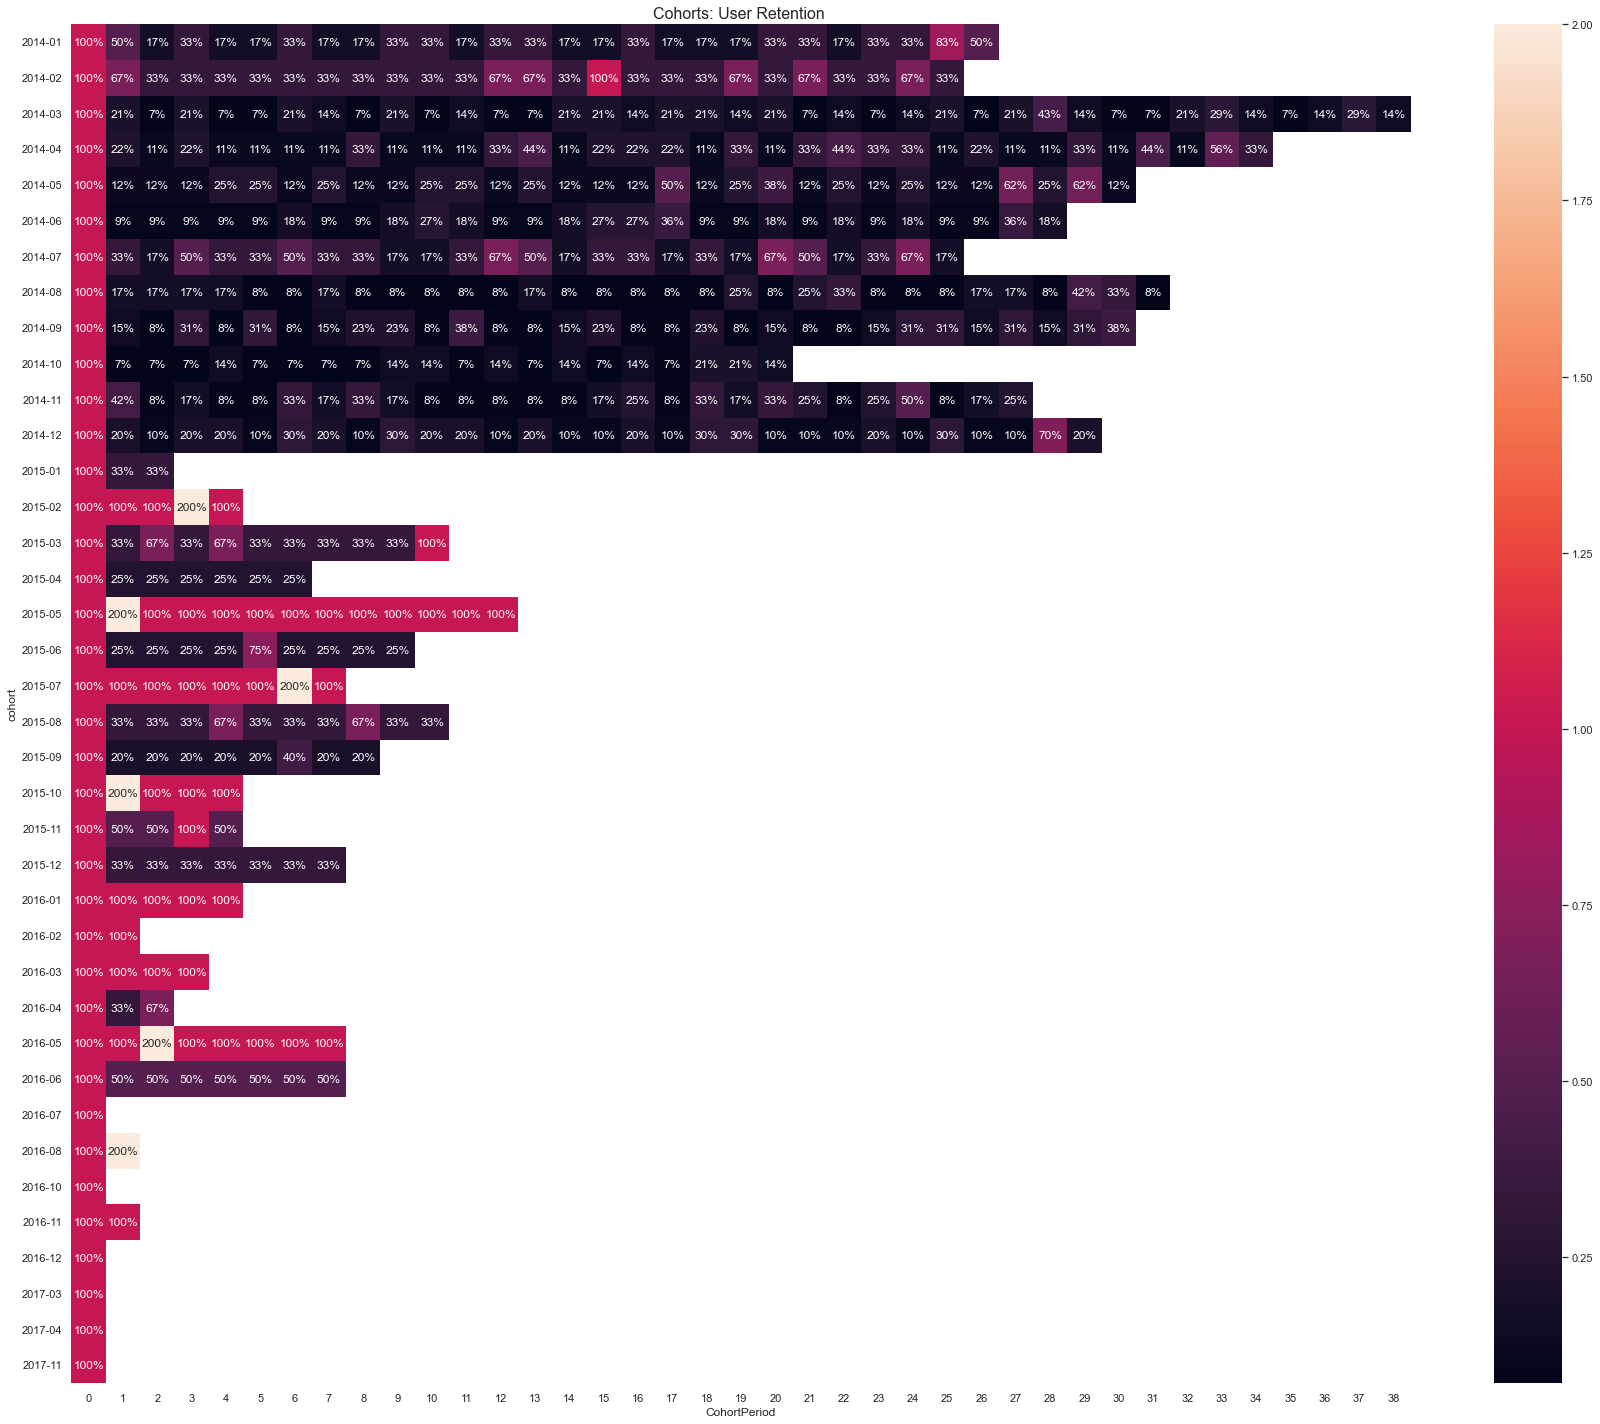

In [38]:
ur_standard_ship = draw_retantion_diagram(df_standard_ship, width=30, height=25);

Видим, что в 2016 и 2017 годах ее использовали редко, поэтому вразумительные выводы мы сделать вряд ли сможем.
Остальные виды доставок осуществлялись еще реже, поэтому из них мы тоже, скорее всего ничего не увидим, но на всякий случай построим графики и для них:

In [39]:
df_first_ship = df_merged[df_merged['ship_mode'] == 'First']

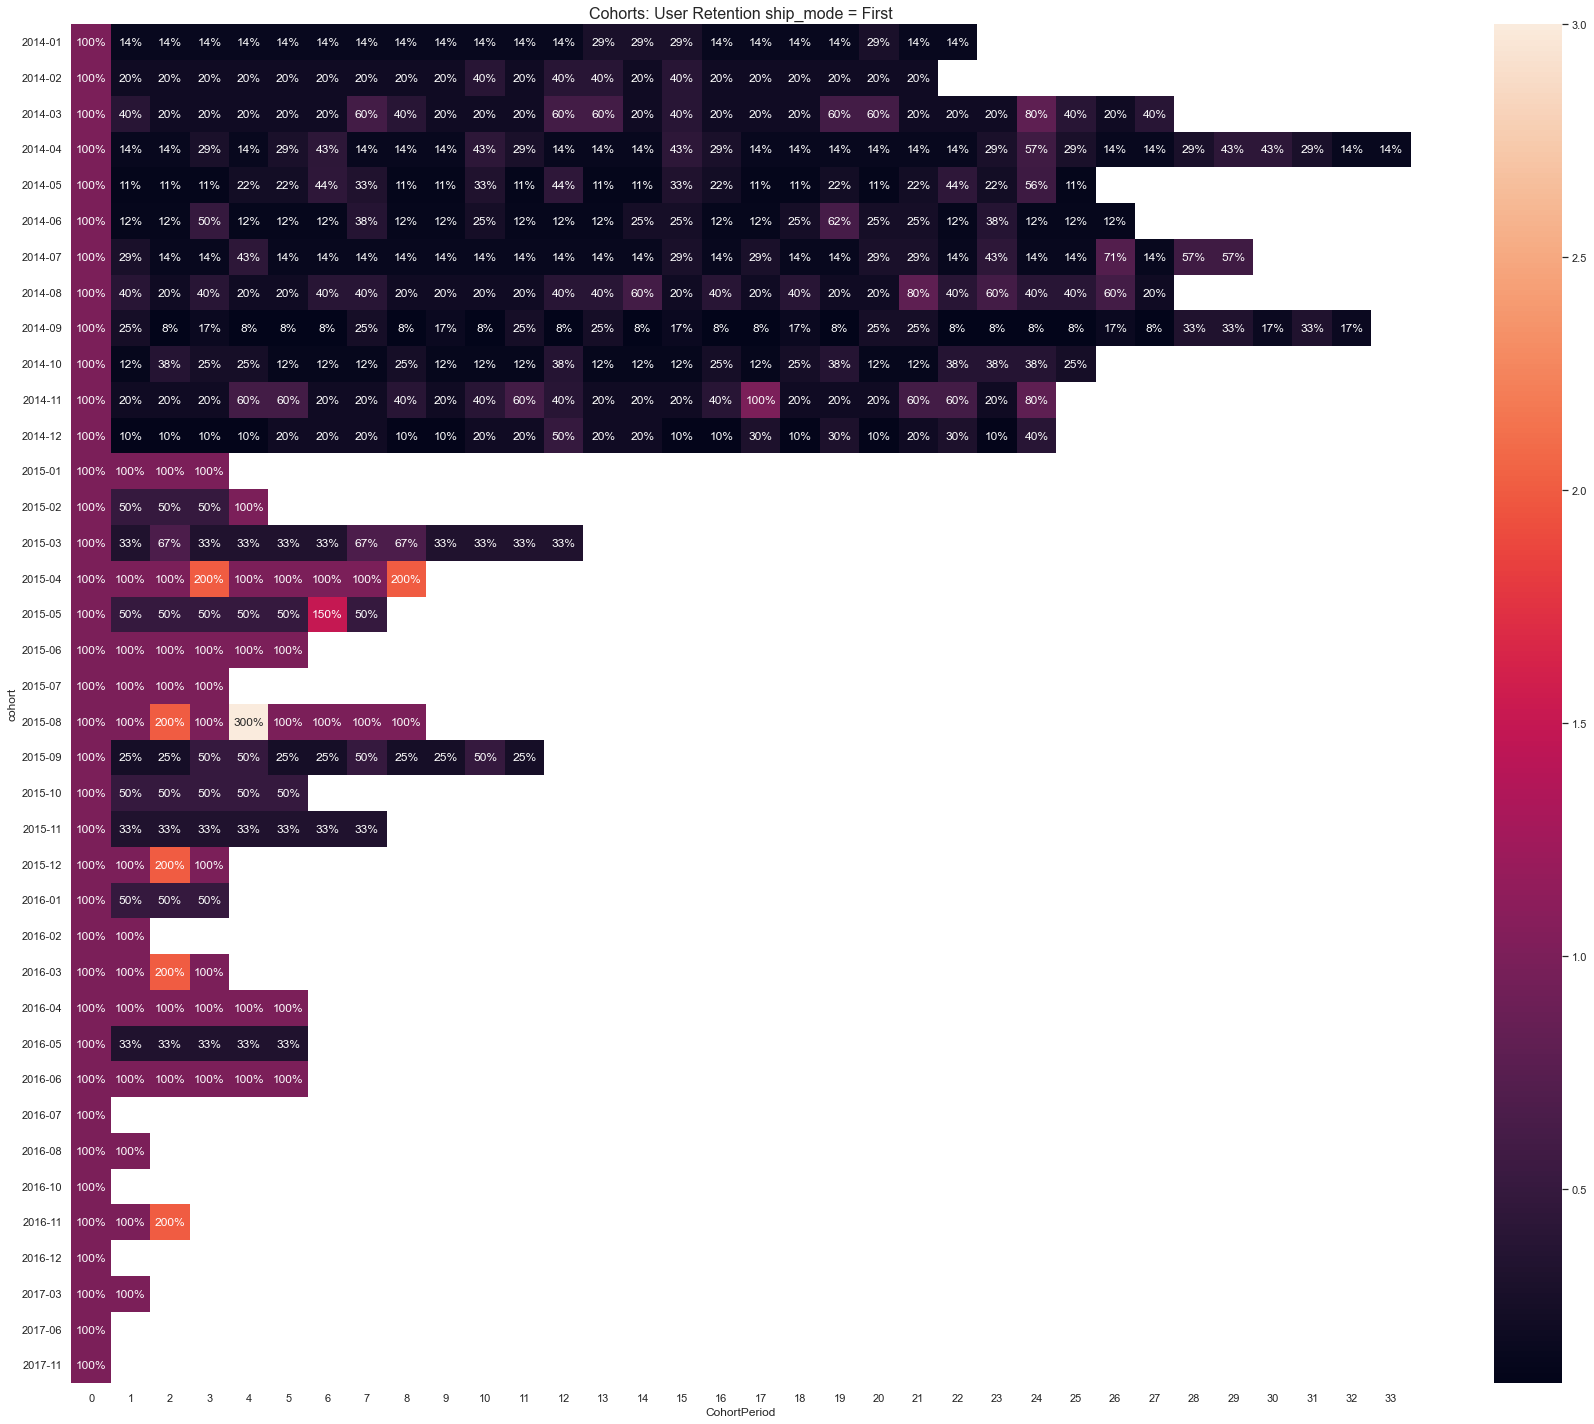

In [40]:
ur_first_ship = draw_retantion_diagram(df_first_ship, width=30, height=25, title='ship_mode = First');

In [41]:
df_second_ship = df_merged[df_merged['ship_mode'] == 'Second']

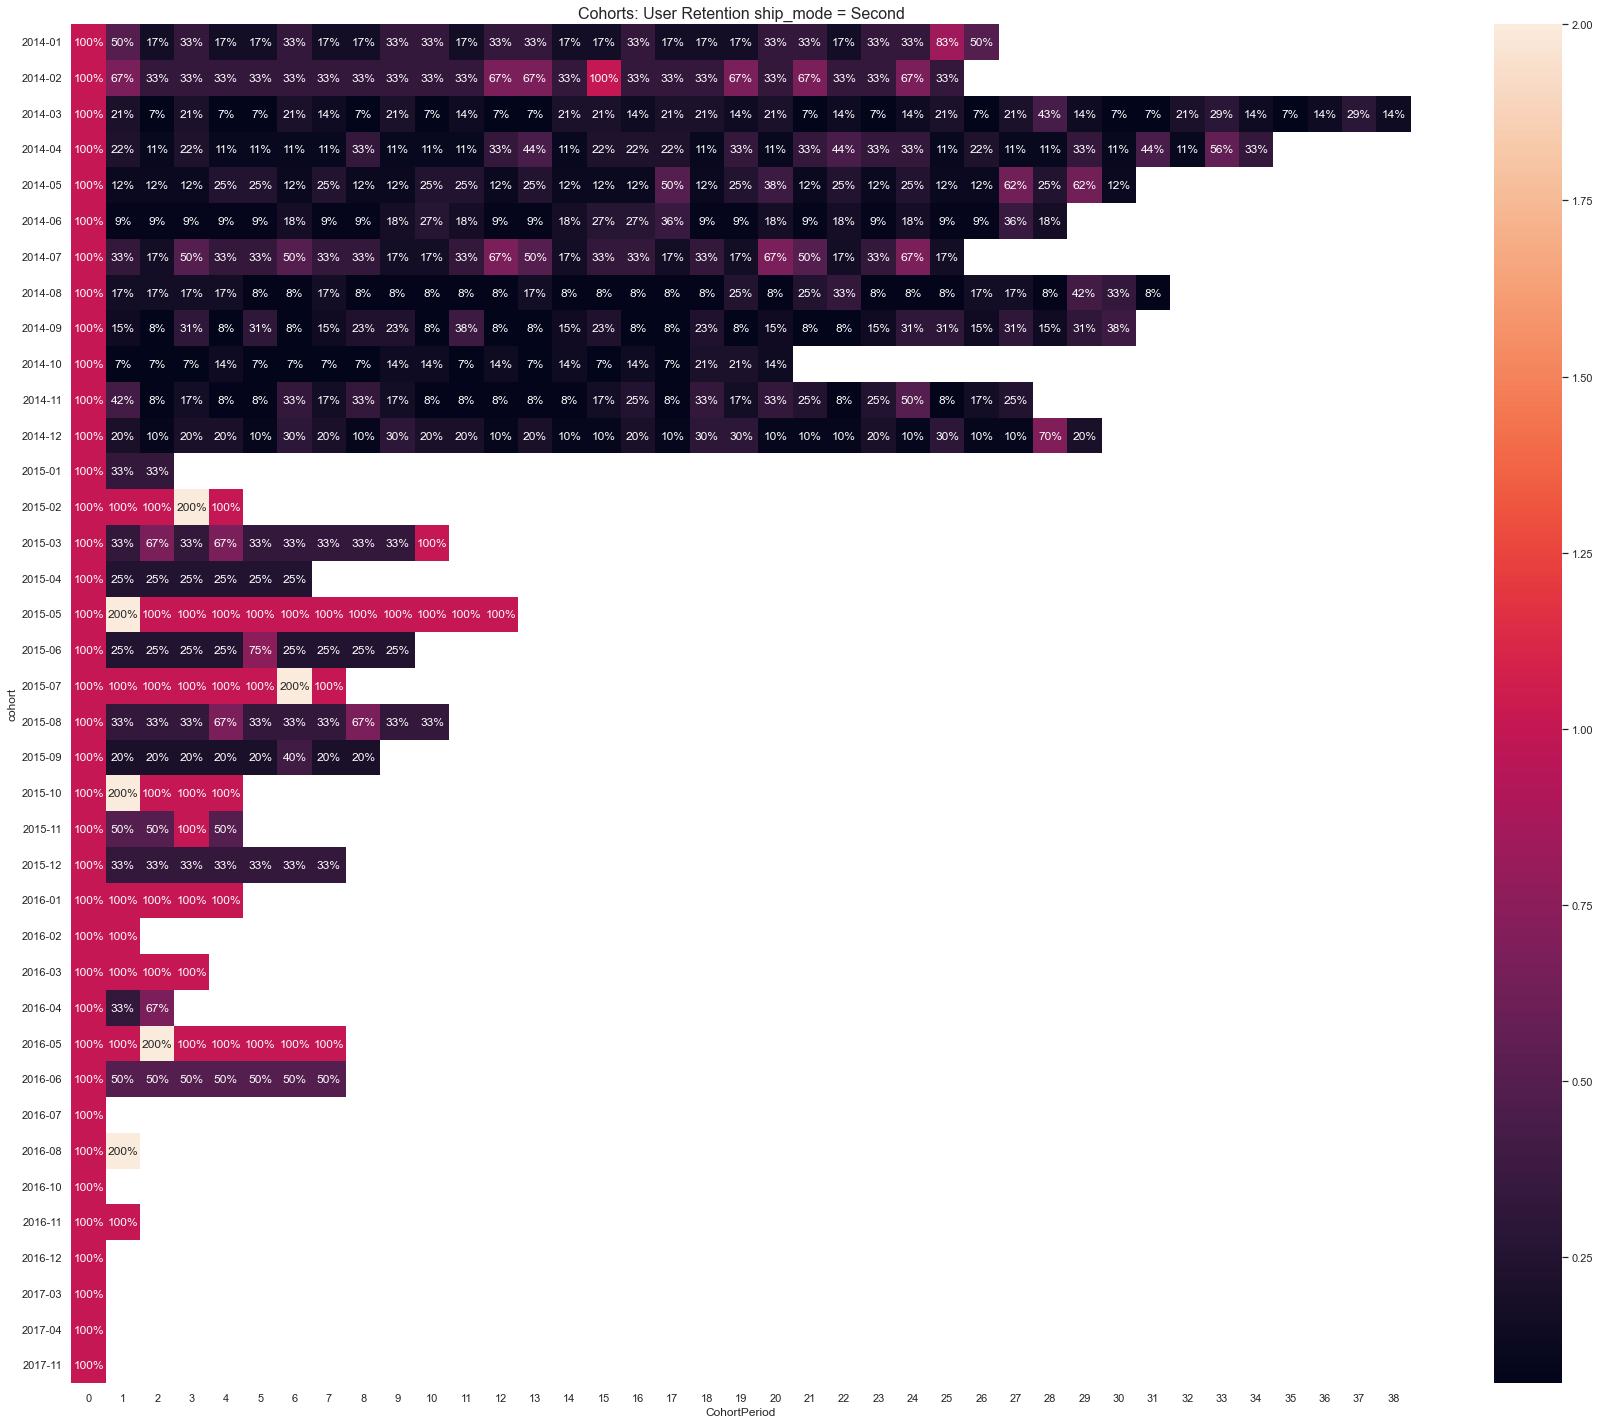

In [42]:
ur_second_ship = draw_retantion_diagram(df_second_ship, width=30, height=25, title='ship_mode = Second')

In [43]:
df_same_day_ship = df_merged[df_merged['ship_mode'] == 'Same Day']

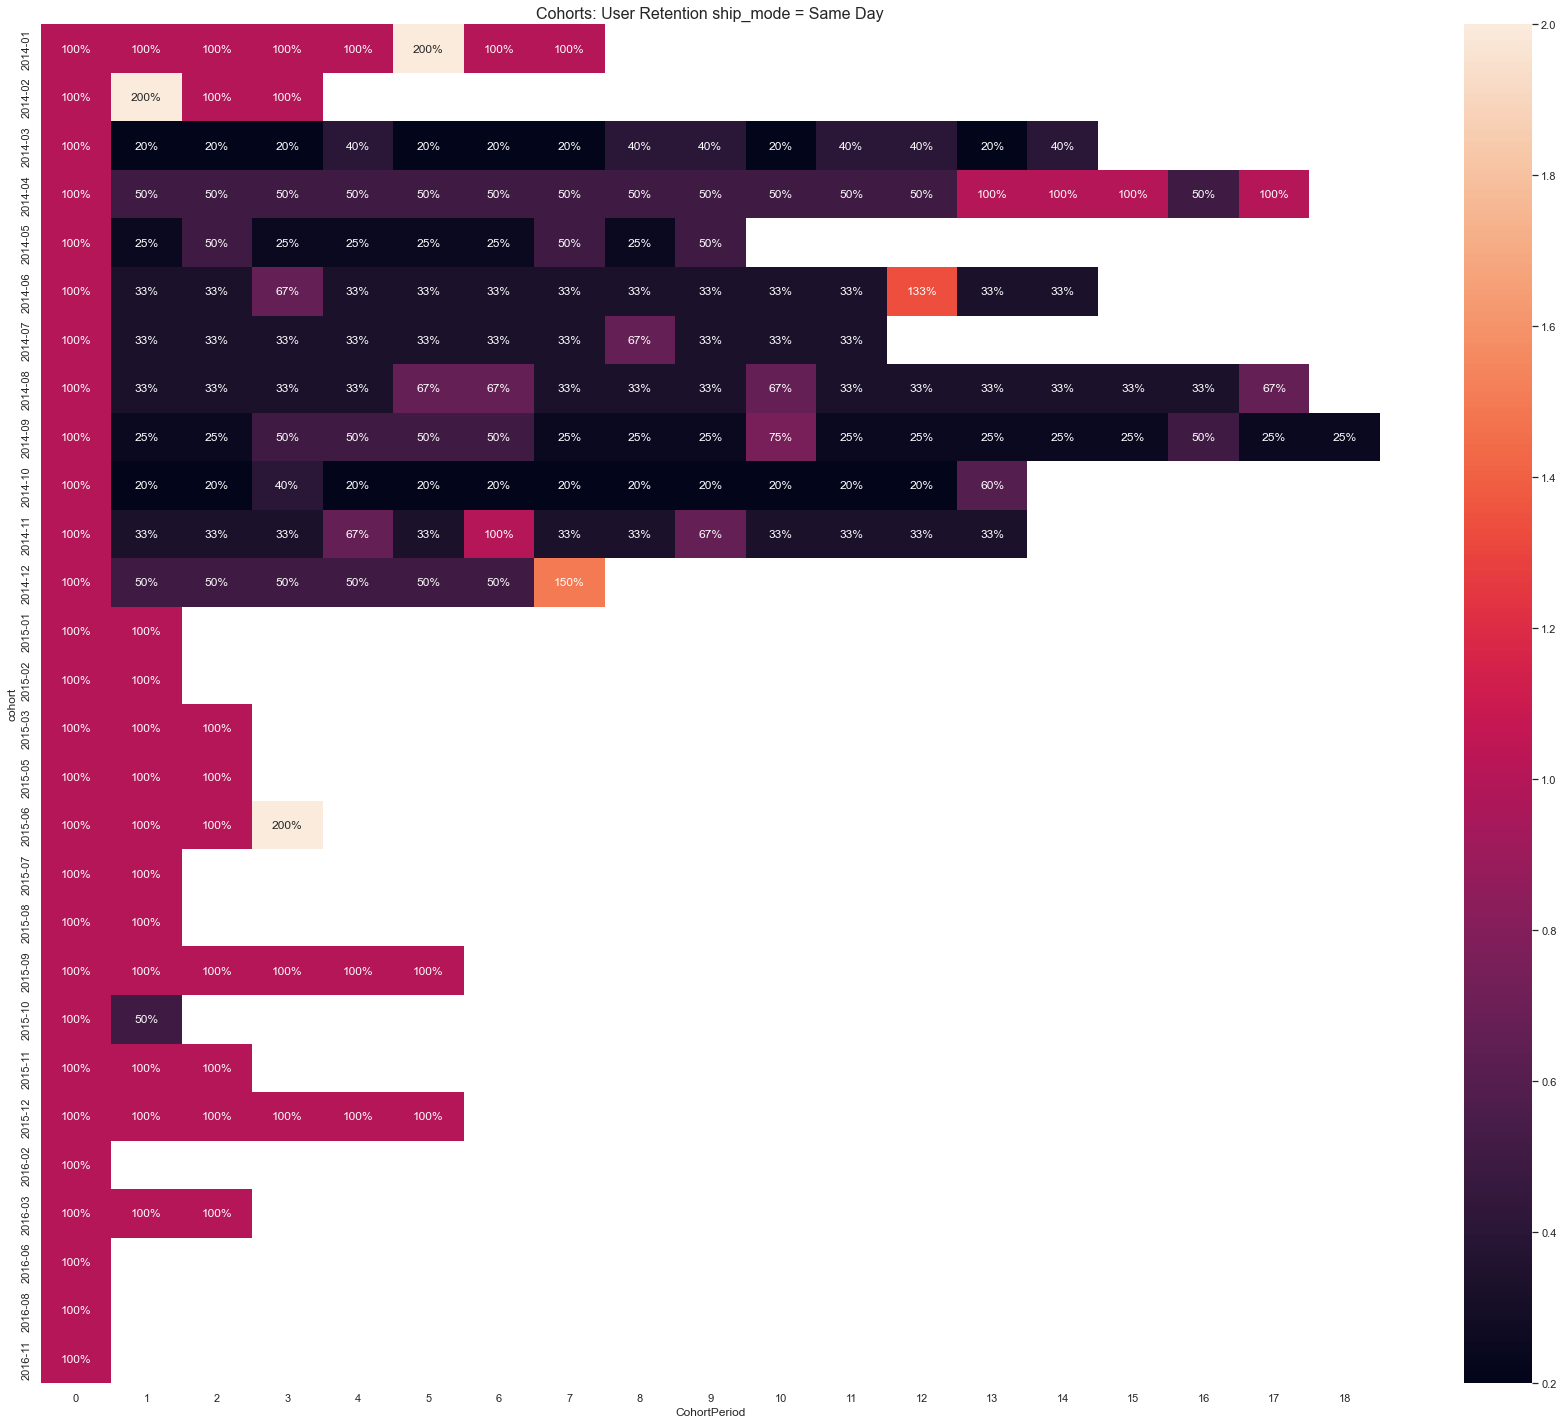

In [44]:
ur_same_day_ship = draw_retantion_diagram(df_same_day_ship, width=30, height=25, title='ship_mode = Same Day')

Таким образом, для любого вида альтернативной доставки видим схожую картину - ими почти не пользуются в 2016 и 2017 годах.